(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random
import Distributions

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Zygote
import Turing
import MCMCChains
import DynamicHMC

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of barcode frequencies

`[explanation here]`

First, let's load the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


## Bayesian model using `Turing.jl`

Let's define the basic probabilistic model with `Turing.jl`.

In [3]:
Turing.@model function multinomial_dirichlet(r̲ₜ, Rₜ, σₜ)

    ## Prior
    # Prior on Dirichlet parameters
    α̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σₜ); lower=0.0), length(r̲ₜ)
    )

    ## Likelihood

    # Dirichlet likelihood for frequencies
    f̲ₜ ~ Turing.Dirichlet(α̲ₜ)

    # Multinomial likelihood for frequencies
    return r̲ₜ ~ Turing.Multinomial(Rₜ, f̲ₜ)

end # Turing.@model

multinomial_dirichlet (generic function with 2 methods)

Let's test the model with some very basic synthetic data.

In [4]:
Random.seed!(42)

# Define synthetic data (from Betancourt's tutorial on Ordinal regression)
data = [2, 4, 13, 22, 9]

# Define model
model = multinomial_dirichlet(data, sum(data), 1.0)

# Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    2_000, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       α̲ₜ[1]    0.6986    0.4218     0.0094    0.0076   2933.6341    1.0008    ⋯
       α̲ₜ[2]    0.7835    0.4711     0.0105    0.0105   2554.4420    1.0000    ⋯
       α̲ₜ[3]    1.0918    0.5831     0.0130    0.0126   2407.1114    0.9998    ⋯
       α̲ₜ[4]    1.2314    0.6224     0.0139    0.0126   2117.0716    1.0012    ⋯
       α̲ₜ[5]    0.9801    0.5417     0.0121    0.0105   2167.0268    0.9996    ⋯
       f̲ₜ[1]    0.0489    0.0300     0.0007    0.0007   3049.5528    1.0004    ⋯
       f̲ₜ[2]    0.0878    0.0418     0.0009    0.0008   3401.6766    0.9995    ⋯
       f̲ₜ[3]    0.2584    0.0603     0.0013    0.0011   2846.8479    0.9995    ⋯
       f̲ₜ[4]    0.4237    0.0666     0.0015    0.0012   3159.8286    0.9999    ⋯
       f̲ₜ[5]    0.1811    0.0528     0.0012    0.0012   2561.9794    0.9995    

Let's take a look at the traces

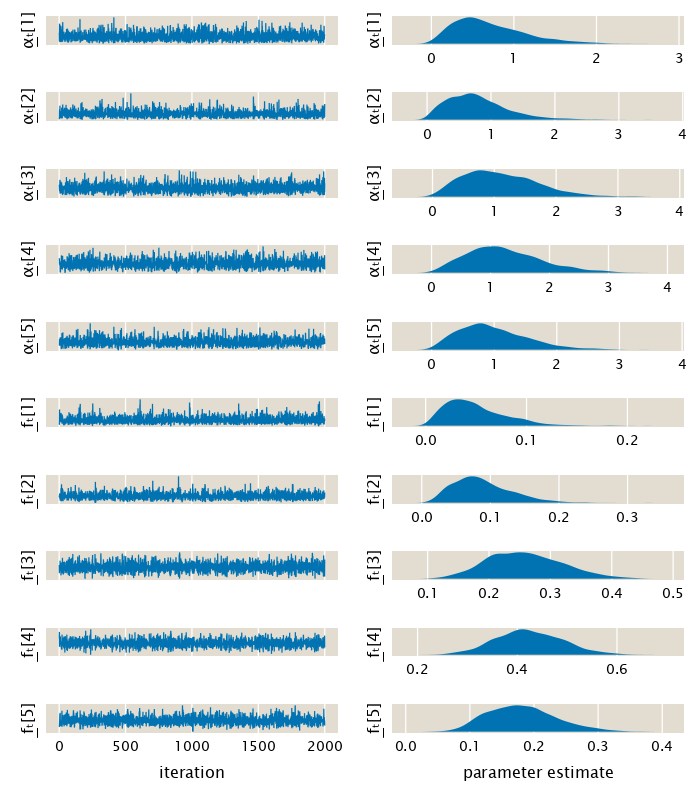

In [5]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(700, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

With such little information ($n=1$) it is not surprising that the uncertainty
is so high.

Let's perform a simple posterior predictive check by generating samples from our
chains. 

In [6]:
# Define quantiles to compute from data
quants = [0.995, 0.95, 0.5]

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of samples
n_samples = length(chain)
# Extract freequency chains
freq_chains = MCMCChains.get_params(chain)[Symbol("f̲ₜ")]
# Extract frequencies into a matrix
freq_samples = hcat([x.data for x in freq_chains]...)
# Define number of parameters
n_param = size(freq_samples, 2)

# Initialize arrays to save posteerior predictive samples
r_ppc = Array{Int64}(undef, n_samples, n_param)

# Loop through samples
for i = 1:n_samples
    # Sample and store a multinomial
    r_ppc[i, :] = Random.rand(
        Distributions.Multinomial(sum(data), freq_samples[i, :])
    )
end # for

# Initialize array to save quantiles
r_ppc_quant = Array{Float64}(undef, length(quants), 2, n_param)

# Loop through quantiles
for (i, q) in enumerate(quants)
    # Compute upper and lower quantile
    r_ppc_quant[i, :, :] = hcat(
        [
                StatsBase.quantile(x, [(1. - q) / 2., 1. - (1. - q) / 2.])
                for x in eachcol(r_ppc)
        ]...
    )
end # for

Let's now plot the posterior predictive checks.

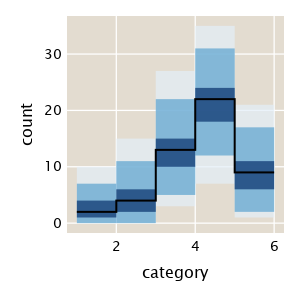

In [7]:
# Inititialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="category",
    ylabel="count",
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0.1, 1, length(quants)))

# Loop through quants
for i = 1:size(r_ppc_quant, 1)
    # Loop through positions
    for j = 1:size(r_ppc_quant, 3)
        # Add band
        band!(
            [j, j+1], 
            repeat([r_ppc_quant[i, 1, j]], 2),
            repeat([r_ppc_quant[i, 2, j]], 2),
            color=(colors[i], 0.7)
        )
    end # for
end # for

# Plot original data
stairs!(ax,  [data; data[end]], step=:post, color=:black, linewidth=2)

fig

Although the credible region is really high, the model was able to recover the
true values within the largest density area.

### Testing inference on real barcode counts

Let's test the method on some of our experimental data. First, let's select data
from `T0` to infer the initial frequencies.

In [45]:
# Define information for data to extract
batch = "Batch1"
hub = "1Day"
perturbation = "28"
rep = "R1"
timepoint = "T0"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep) .&
        (df.timepoint .== timepoint)
    ,
:]
# Sort by count
DF.sort!(data, :count)

last(data[:, [:timepoint, :count]], 5)

Row,timepoint,count
,String3,Int64
1,T0,5352
2,T0,5602
3,T0,5654
4,T0,6180
5,T0,17062


To get the inference to run, using Hamiltonian Monte Carlo is impossibly slow. I
am not sure if this is a particular bug on computing something related to the
Dirichlet distribution, or the intrinsic computational cost of the gradients at
each step for a very large model becomes a limiting step.

Nevertheless, we can use one clever property from the Dirichlet distribution:
aggregation. As explained in Wikipedia
> If
$$
X=\left(X_1, \ldots, X_K\right) \sim 
\operatorname{Dir}\left(\alpha_1, \ldots, \alpha_K\right)
$$
> then, if the random variables with subscripts $i$ and $j$ are dropped from the
> vector and replaced by their sum,
$$
X^{\prime}=\left(X_1, \ldots, X_i+X_j, \ldots, X_K\right) \sim 
\operatorname{Dir}\left(
    \alpha_1, \ldots, \alpha_i+\alpha_j, \ldots, \alpha_K
\right) .
$$

Given this property and the structure of our dataset, we can simplify the
inference.

In [9]:
Random.seed!(42)

# Switch Automatic differentiation backend
Turing.setadbackend(:zygote)

# Define model
model = multinomial_dirichlet(data.count, sum(data.count), 100.0)

# Sample
chain = Turing.sample(
    model, 
    Turing.IS(),
    Turing.MCMCThreads(), 
    4_000,
    4, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

       α̲ₜ[1]   80.2677   60.9148     0.4816    0.4797   15417.6951    0.9999   ⋯
       α̲ₜ[2]   79.6672   60.4512     0.4779    0.4851   16125.8617    0.9999   ⋯
       α̲ₜ[3]   79.6891   60.7081     0.4799    0.4658   15509.9665    0.9998   ⋯
       α̲ₜ[4]   79.7879   60.5590     0.4788    0.4752   15059.0973    0.9999   ⋯
       α̲ₜ[5]   78.3495   59.1831     0.4679    0.4355   15615.2393    1.0000   ⋯
       α̲ₜ[6]   79.7116   60.3872     0.4774    0.5429   14906.5188    0.9999   ⋯
       α̲ₜ[7]   79.9264   60.4145     0.4776    0.5216   15314.7752    1.0001   ⋯
       α̲ₜ[8]   79.7172   60.4434     0.4778    0.4844   15661.4095    1.0002   ⋯
       α̲ₜ[9]   78.6700   59.7529     0.4724    0.4316   16218.1791    0.9999   ⋯
      α̲ₜ[10]   80.2349   60.5048     0.4783    0.5173   16237.4247    0.9999   

the $\hat{R}$ (`rhat`) values and the effective sample size (`ess`) both pass
the quick eye test. Let's compute the posterior predictive checks.

In [10]:
# Define quantiles to compute from data
quants = [0.995, 0.95, 0.5]

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of samples
n_samples = length(chain)
# Extract freequency chains
freq_chains = MCMCChains.get_params(chain)[Symbol("f̲ₜ")]
# Extract frequencies into a matrix
freq_samples = hcat([vec(x.data) for x in freq_chains]...)
# Define number of parameters
n_param = size(freq_samples, 2)

# Initialize arrays to save posteerior predictive samples
r_ppc = Array{Int64}(undef, n_samples, n_param)

# Loop through samples
Threads.@threads for i = 1:n_samples
    # Sample and store a multinomial
    r_ppc[i, :] = Random.rand(
        Distributions.Multinomial(sum(data.count), freq_samples[i, :])
    )
end # for

# Initialize array to save quantiles
r_ppc_quant = Array{Float64}(undef, length(quants), 2, n_param)

# Loop through quantiles
for (i, q) in enumerate(quants)
    # Compute upper and lower quantile
    r_ppc_quant[i, :, :] = hcat(
        [
                StatsBase.quantile(x, [(1. - q) / 2., 1. - (1. - q) / 2.])
                for x in eachcol(r_ppc)
        ]...
    )
end # for

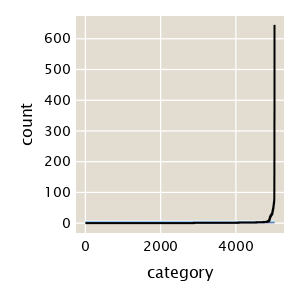

In [12]:
# Inititialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="category",
    ylabel="count",
    # yscale=log10
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0.1, 1, length(quants)))

# Loop through quants
for i = 1:size(r_ppc_quant, 1)
    # Loop through positions
    for j = 1:size(r_ppc_quant, 3)
        # Add band
        band!(
            [j, j+1], 
            repeat([r_ppc_quant[i, 1, j]], 2),
            repeat([r_ppc_quant[i, 2, j]], 2),
            color=(colors[i], 0.7)
        )
    end # for
end # for

# Plot original data
stairs!(
    ax, 
    # [data.count[data.count .> 0]; data.count[end]], 
    [data.count; data.count[end]], 
    step=:post, 
    color=:black, 
    linewidth=2
)

fig

## Testing different priors

Changing prior for hyper parameters

In [13]:
Turing.@model function multinomial_dirichlet_prior(r̲ₜ, Rₜ, α̲ₚ, σₜ)

    ## Prior
    # Prior on Dirichlet parameters
    # Initialize parameter vector
    α̲ₜ = Vector{Float64}(undef, length(α̲ₚ))

    # Loop through priors
    for i = 1:length(α̲ₚ)
        α̲ₜ[i] ~ Turing.truncated(Turing.Normal(α̲ₚ[i], σₜ); lower=0.0)
    end # for

    ## Likelihood

    # Dirichlet likelihood for frequencies
    f̲ₜ ~ Turing.Dirichlet(α̲ₜ)

    # Multinomial likelihood for frequencies
    return r̲ₜ ~ Turing.Multinomial(Rₜ, f̲ₜ)

end # Turing.@model

multinomial_dirichlet_prior (generic function with 2 methods)

In [19]:
Random.seed!(42)

# Switch Automatic differentiation backend
Turing.setadbackend(:zygote)

# Define model
model = multinomial_dirichlet_prior(
    data.count, sum(data.count), data.count .+ 1, 10
)

# Sample
chain = Turing.sample(
    model, 
    Turing.IS(),
    Turing.MCMCThreads(), 
    1_000,
    4, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       α̲ₜ[1]    8.2839    6.1706     0.0976    0.0959   3944.3576    1.0008    ⋯
       α̲ₜ[2]    8.4164    6.2543     0.0989    0.0869   4125.0245    0.9996    ⋯
       α̲ₜ[3]    8.4856    6.3105     0.0998    0.1142   3847.2518    0.9993    ⋯
       α̲ₜ[4]    8.3883    6.2885     0.0994    0.0867   3960.8882    0.9996    ⋯
       α̲ₜ[5]    8.3573    6.1518     0.0973    0.0958   3911.5506    0.9998    ⋯
       α̲ₜ[6]    8.3546    6.1776     0.0977    0.1068   3884.3651    1.0004    ⋯
       α̲ₜ[7]    8.4029    6.3661     0.1007    0.1020   4018.1057    1.0000    ⋯
       α̲ₜ[8]    8.4640    6.2083     0.0982    0.1011   4194.3615    0.9996    ⋯
       α̲ₜ[9]    8.3873    6.2689     0.0991    0.0785   4060.5072    0.9993    ⋯
      α̲ₜ[10]    8.3440    6.1117     0.0966    0.0816   4077.3998    0.9996    

In [20]:
# Define quantiles to compute from data
quants = [0.995, 0.95, 0.5]

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of samples
n_samples = length(chain)
# Extract freequency chains
freq_chains = MCMCChains.get_params(chain)[Symbol("f̲ₜ")]
# Extract frequencies into a matrix
freq_samples = hcat([vec(x.data) for x in freq_chains]...)
# Define number of parameters
n_param = size(freq_samples, 2)

# Initialize arrays to save posteerior predictive samples
r_ppc = Array{Int64}(undef, n_samples, n_param)

# Loop through samples
Threads.@threads for i = 1:n_samples
    # Sample and store a multinomial
    r_ppc[i, :] = Random.rand(
        Distributions.Multinomial(sum(data.count), freq_samples[i, :])
    )
end # for

# Initialize array to save quantiles
r_ppc_quant = Array{Float64}(undef, length(quants), 2, n_param)

# Loop through quantiles
for (i, q) in enumerate(quants)
    # Compute upper and lower quantile
    r_ppc_quant[i, :, :] = hcat(
        [
                StatsBase.quantile(x, [(1. - q) / 2., 1. - (1. - q) / 2.])
                for x in eachcol(r_ppc)
        ]...
    )
end # for

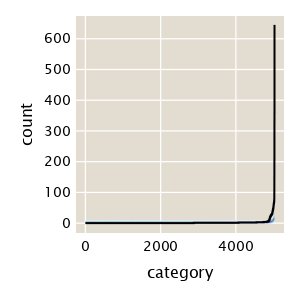

In [22]:
# Inititialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="category",
    ylabel="count",
    # yscale=log10
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0.1, 1, length(quants)))

# Loop through quants
for i = 1:size(r_ppc_quant, 1)
    # Loop through positions
    for j = 1:size(r_ppc_quant, 3)
        # Add band
        band!(
            [j, j+1], 
            repeat([r_ppc_quant[i, 1, j]], 2),
            repeat([r_ppc_quant[i, 2, j]], 2),
            color=(colors[i], 0.7)
        )
    end # for
end # for

# Plot original data
stairs!(
    ax, 
    [data.count; data.count[end]], 
    step=:post, 
    color=:black, 
    linewidth=2
)

fig

# Combining entries

In [36]:
# Count rows with a particular count number
data_bin = DF.combine(DF.groupby(data, :count, sort=true), DF.nrow)
# Add column with added counts
data_bin[!, :total] = data_bin.count .* data_bin.nrow

last(data_bin, 10)

Row,count,nrow,total
,Int64,Int64,Int64
1,71,2,142
2,72,1,72
3,76,1,76
4,79,1,79
5,106,1,106
6,152,1,152
7,206,1,206
8,329,1,329
9,359,1,359


In [42]:
Random.seed!(42)

# Switch Automatic differentiation backend
Turing.setadbackend(:zygote)

# Define model
model = multinomial_dirichlet(data_bin.total, sum(data_bin.total), 100.0)

# Sample
chain = Turing.sample(
    model, 
    # Turing.IS(),
    Turing.NUTS(0.65),
    Turing.MCMCThreads(), 
    1_000,
    4, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

       α̲ₜ[1]     0.8602    0.7822     0.0124    0.0224   1158.0250    1.0025   ⋯
       α̲ₜ[2]   471.9881   44.1736     0.6984    1.7541    604.6560    1.0015   ⋯
       α̲ₜ[3]   382.4890   37.5557     0.5938    1.4637    583.9332    1.0023   ⋯
       α̲ₜ[4]   239.6193   26.6563     0.4215    0.9187    766.0146    1.0013   ⋯
       α̲ₜ[5]   137.6331   18.0831     0.2859    0.5525    922.4382    0.9993   ⋯
       α̲ₜ[6]    60.0601   10.4936     0.1659    0.2890   1334.9808    1.0007   ⋯
       α̲ₜ[7]    46.7089    8.9636     0.1417    0.2261   1542.8890    1.0013   ⋯
       α̲ₜ[8]    22.1524    5.7796     0.0914    0.1474   1563.2828    0.9998   ⋯
       α̲ₜ[9]    28.4355    6.6709     0.1055    0.1765   1491.2860    1.0011   ⋯
      α̲ₜ[10]     9.0370    3.4003     0.0538    0.0675   2586.3279    0.9997   

In [43]:
# Define quantiles to compute from data
quants = [0.995, 0.95, 0.5]

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of samples
n_samples = length(chain)
# Extract freequency chains
freq_chains = MCMCChains.get_params(chain)[Symbol("f̲ₜ")]
# Extract frequencies into a matrix
freq_samples = hcat([vec(x.data) for x in freq_chains]...)
# Define number of parameters
n_param = size(freq_samples, 2)

# Initialize arrays to save posteerior predictive samples
r_ppc = Array{Int64}(undef, n_samples, n_param)

# Loop through samples
Threads.@threads for i = 1:n_samples
    # Sample and store a multinomial
    r_ppc[i, :] = Random.rand(
        Distributions.Multinomial(sum(data_bin.total), freq_samples[i, :])
    )
end # for

# Initialize array to save quantiles
r_ppc_quant = Array{Float64}(undef, length(quants), 2, n_param)

# Loop through quantiles
for (i, q) in enumerate(quants)
    # Compute upper and lower quantile
    r_ppc_quant[i, :, :] = hcat(
        [
                StatsBase.quantile(x, [(1. - q) / 2., 1. - (1. - q) / 2.])
                for x in eachcol(r_ppc)
        ]...
    )
end # for

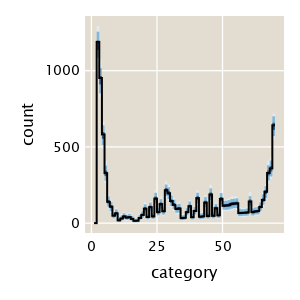

In [44]:
# Inititialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="category",
    ylabel="count",
    # yscale=log10
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0.1, 1, length(quants)))

# Loop through quants
for i = 1:size(r_ppc_quant, 1)
    # Loop through positions
    for j = 1:size(r_ppc_quant, 3)
        # Add band
        band!(
            [j, j+1], 
            repeat([r_ppc_quant[i, 1, j]], 2),
            repeat([r_ppc_quant[i, 2, j]], 2),
            color=(colors[i], 0.7)
        )
    end # for
end # for

# Plot original data
stairs!(
    ax, 
    [data_bin.total; data_bin.total[end]], 
    step=:post, 
    color=:black, 
    linewidth=2
)

fig